In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.layers as L


In [2]:
np.random.seed(42)

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [5]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
 
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [8]:
batch_size = 16
lr = 1e-4
num_epochs = 100
dataset_path="/kaggle/input/brain-tumor-segmentation"
model_path = os.path.join("files", "attention_unet.keras")
csv_path = os.path.join("files", "log.csv")

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [11]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (H,W, 3)
    model = attention_unet(input_shape)
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])
    model.summary()

Model: "Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 8,143,169 (31.06 MB)

 Trainable params: 8,135,745 (31.04 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [12]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [13]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7811 - dice_coef: 0.1115 - loss: 0.8885
Epoch 1: val_loss improved from inf to 0.97211, saving model to files/attention_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 125s 649ms/step - accuracy: 0.7821 - dice_coef: 0.1119 - loss: 0.8881 - val_accuracy: 0.9823 - val_dice_coef: 0.0278 - val_loss: 0.9721 - learning_rate: 1.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9680 - dice_coef: 0.2399 - loss: 0.7601
Epoch 2: val_loss improved from 0.97211 to 0.97107, saving model to files/attention_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 563ms/step - accuracy: 0.9681 - dice_coef: 0.2400 - loss: 0.7600 - val_accuracy: 0.9823 - val_dice_coef: 0.0288 - val_loss: 0.9711 - learning_rate: 1.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9778 - dice_coef: 0.3211 - loss: 0.6789
Epoch 3: val_loss improved from 0.97107 to 0.92018, saving model to files/attention_unet.keras
115/115

In [14]:
model.save('attention_unet.keras')

In [15]:
import pandas as pd
metrics = pd.read_csv("/kaggle/working/files/log.csv")
metrics

,epoch,accuracy,dice_coef,learning_rate,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.887086,0.154561,1.000000e-04,0.845439,0.982257,0.027839,0.972113
1,1,0.971823,0.255189,1.000000e-04,0.744811,0.982257,0.028846,0.971072
2,2,0.980162,0.336702,1.000000e-04,0.663298,0.968945,0.080466,0.920178
3,3,0.983967,0.410815,1.000000e-04,0.589185,0.970872,0.194585,0.806078
4,4,0.987361,0.492856,1.000000e-04,0.507144,0.983027,0.076926,0.921991
5,5,0.989661,0.569844,1.000000e-04,0.430156,0.987433,0.430075,0.571633
6,6,0.990931,0.630657,1.000000e-04,0.369343,0.986957,0.451192,0.548926
7,7,0.991820,0.676055,1.000000e-04,0.323944,0.988493,0.494141,0.505289
8,8,0.992402,0.709122,1.000000e-04,0.290878,0.989673,0.628996,0.371846
9,9,0.993240,0.749403,1.000000e-04,0.250597,0.988990,0.560892,0.439394


<Axes: >

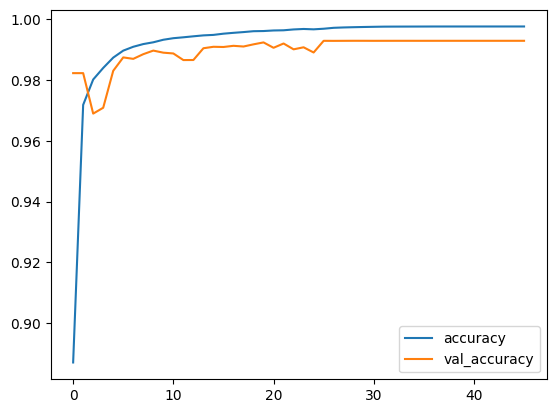

In [16]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

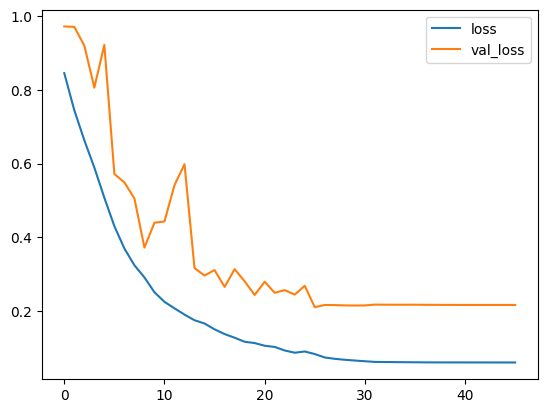

In [17]:
metrics[['loss','val_loss']].plot()

In [18]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [19]:
results = model.evaluate(test_dataset)

# Print Results
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[2]:.4f}")
print(f"Test Dice Coefficient: {results[1]*100:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.9924 - dice_coef: 0.7648 - loss: 0.2354
Test Loss: 0.2391
Test Accuracy: 0.9926
Test Dice Coefficient: 76.3928


In [20]:
print(metrics['dice_coef'])

0     0.154561
1     0.255189
2     0.336702
3     0.410815
4     0.492856
5     0.569844
6     0.630657
7     0.676055
8     0.709122
9     0.749403
10    0.775425
11    0.793002
12    0.810094
13    0.825403
14    0.834225
15    0.850080
16    0.862806
17    0.872810
18    0.883781
19    0.887321
20    0.894584
21    0.897827
22    0.907473
23    0.913526
24    0.910207
25    0.917161
26    0.926426
27    0.930122
28    0.932669
29    0.934790
30    0.936656
31    0.938461
32    0.938810
33    0.939047
34    0.939267
35    0.939481
36    0.939765
37    0.939805
38    0.939837
39    0.939865
40    0.939891
41    0.939918
42    0.939944
43    0.939971
44    0.939998
45    0.940026
Name: dice_coef, dtype: float64


In [21]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [22]:
from tqdm import tqdm
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)
    '''
    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)
    '''

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [01:43<00:00,  5.89it/s]

F1: 0.71556
Jaccard: 0.62492
Recall: 0.69221
Precision: 0.81677


In [23]:
scores = pd.read_csv("/kaggle/working/files/score.csv")
scores

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.906667,0.829268,0.838028,0.987552
1,2069.png,0.905865,0.827928,0.977660,0.843893
2,3038.png,0.447858,0.288542,0.749221,0.319389
3,1169.png,0.969863,0.941489,0.953664,0.986622
4,501.png,0.932496,0.873529,0.874816,0.998319
...,...,...,...,...,...
607,1675.png,0.825000,0.702128,0.804878,0.846154
608,429.png,0.960000,0.923077,0.941176,0.979592
609,344.png,0.942370,0.891021,0.911303,0.975630
610,2667.png,0.878833,0.783856,0.795687,0.981383


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


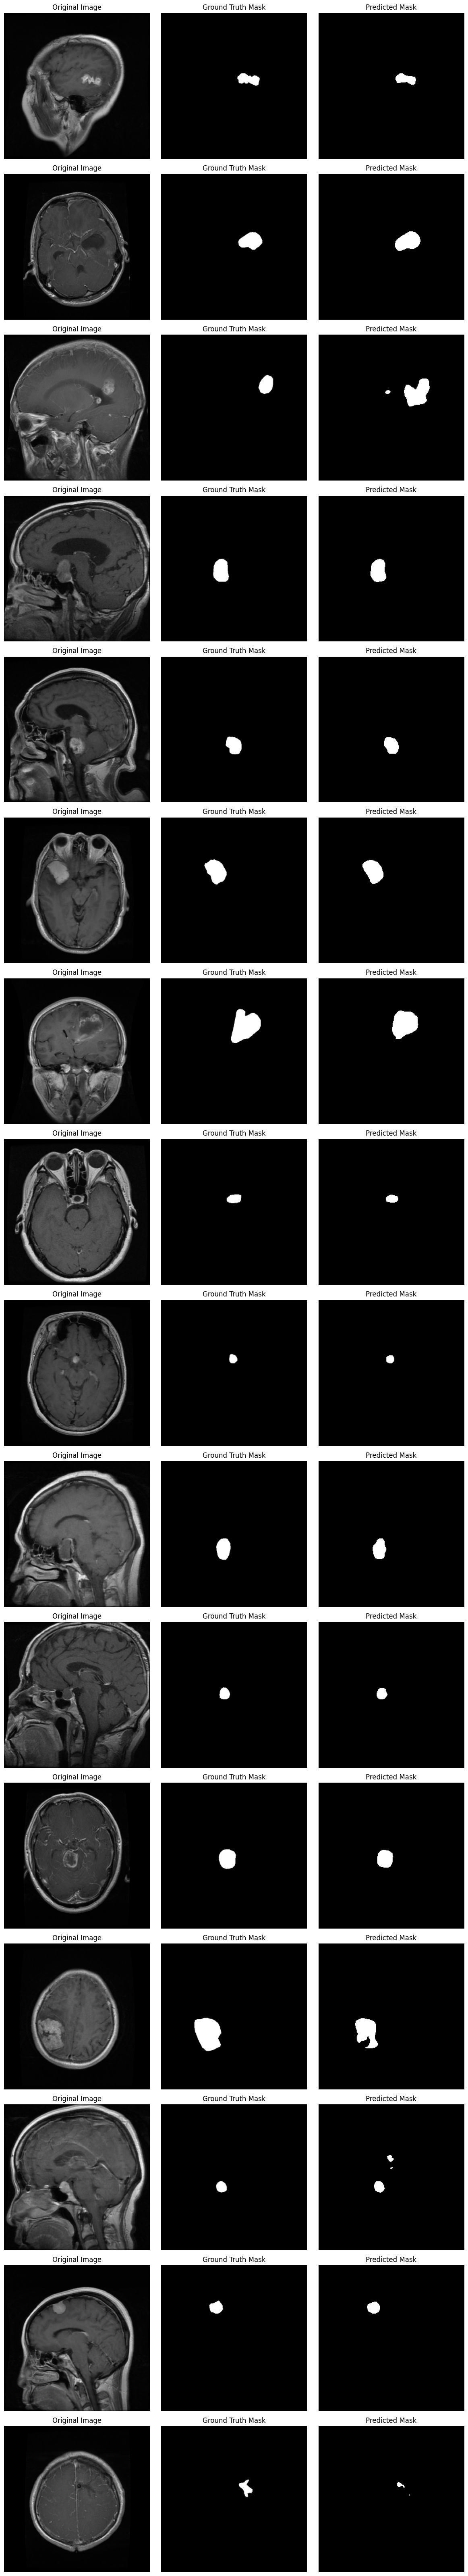

In [24]:
# Take one batch from the test dataset
for x, y_true in test_dataset.take(1):  
    y_pred = model.predict(x)  # Get predictions
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert to binary masks

    batch_size = x.shape[0]  # Number of images in batch

    # Plot images, ground truth, and predictions
    plt.figure(figsize=(12, 4 * batch_size))  # Adjust figure size

    for i in range(batch_size):
        # Original Image
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(x[i])  # Show original image
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(y_true[i, :, :, 0], cmap="gray")  # Show ground truth
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(y_pred[i, :, :, 0], cmap="gray")  # Show predicted mask
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break  # Only visualize one batch
